## Population Threshold Selection

Determine optimal population threshold to balance:
- Data completeness (minimize missingness from CDC suppression)
- Sample size (maintain statistical power)
- Geographic coverage (retain enough counties)

**Approach**: Analyze missingness vs. population threshold to find "elbow point" where curve flattens.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("mode.copy_on_write", True)
sns.set_style("whitegrid")

### Load Merged Data

In [17]:
# Load final merged dataset
df = pd.read_csv("../01_data/clean/final_merged.csv")

print("=== FINAL MERGED DATA ===")
print(f"Total observations: {len(df)}")
print(
    f"Observations WITH mortality data: {df['Deaths'].notna().sum()} ({df['Deaths'].notna().mean()*100:.1f}%)"
)
print(
    f"Observations WITHOUT mortality data: {df['Deaths'].isna().sum()} ({df['Deaths'].isna().mean()*100:.1f}%)"
)
print(f"\nYear range: {df['Year'].min()}-{df['Year'].max()}")
print(f"Unique counties: {df['CTYNAME'].nunique()}")

=== FINAL MERGED DATA ===
Total observations: 6336
Observations WITH mortality data: 1589 (25.1%)
Observations WITHOUT mortality data: 4747 (74.9%)

Year range: 2006-2015
Unique counties: 473


### Test Population Thresholds

CDC suppresses mortality data for counties with <10 deaths. We test different population thresholds to find where missingness becomes acceptable.

In [18]:
# Test thresholds from 10K to 500K
thresholds = [
    10000,
    20000,
    30000,
    40000,
    50000,
    75000,
    100000,
    150000,
    200000,
    250000,
    300000,
    350000,
    400000,
    500000,
]

results = []
for threshold in thresholds:
    # Filter to observations above threshold
    above_threshold = df[df["population"] >= threshold]

    # Calculate statistics
    total_obs = len(above_threshold)
    unique_counties = above_threshold["CTYNAME"].nunique()

    # Calculate missingness
    missing_deaths = above_threshold["Deaths"].isna().sum()
    pct_missing = (missing_deaths / total_obs * 100) if total_obs > 0 else 0

    results.append(
        {
            "Threshold": threshold,
            "Total Observations": total_obs,
            "Unique Counties": unique_counties,
            "Missing Deaths": missing_deaths,
            "Pct Missing": pct_missing,
        }
    )

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 Threshold  Total Observations  Unique Counties  Missing Deaths  Pct Missing
     10000                5116              397            3527    68.940579
     20000                4030              323            2441    60.570720
     30000                3107              257            1529    49.211458
     40000                2708              227            1150    42.466765
     50000                2369              202             826    34.867033
     75000                1801              162             425    23.598001
    100000                1455              132             204    14.020619
    150000                1043               97              53     5.081496
    200000                 747               73              12     1.606426
    250000                 608               58               6     0.986842
    300000                 484               47               0     0.000000
    350000                 399               39               0     0.000000

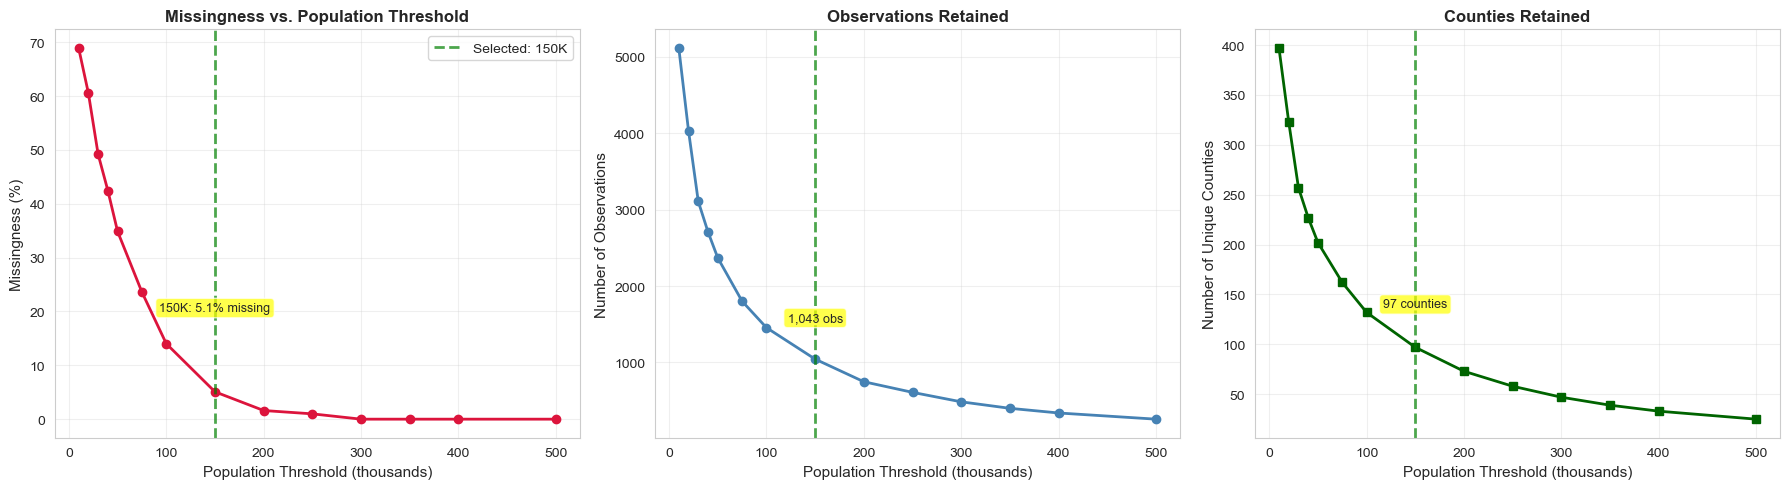


✓ Selected threshold: 150,000 population
  - Missingness: 5.1%
  - Observations: 1,043
  - Counties: 97

Figure saved to: ../05_outputs/figures/threshold_selection.png


In [19]:
# Create visualization with missingness overlay
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Missingness vs Threshold
ax1 = axes[0]
ax1.plot(
    results_df["Threshold"] / 1000,
    results_df["Pct Missing"],
    marker="o",
    linewidth=2,
    markersize=6,
    color="crimson",
)
ax1.set_xlabel("Population Threshold (thousands)", fontsize=11)
ax1.set_ylabel("Missingness (%)", fontsize=11)
ax1.set_title("Missingness vs. Population Threshold", fontsize=12, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.axvline(
    150, color="green", linestyle="--", linewidth=2, alpha=0.7, label="Selected: 150K"
)
ax1.legend()

# Annotate selected threshold
idx_150 = results_df[results_df["Threshold"] == 150000].index[0]
miss_150 = results_df.loc[idx_150, "Pct Missing"]
ax1.annotate(
    f"150K: {miss_150:.1f}% missing",
    xy=(150, miss_150),
    xytext=(150, miss_150 + 15),
    ha="center",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
)

# Plot 2: Observations vs Threshold
ax2 = axes[1]
ax2.plot(
    results_df["Threshold"] / 1000,
    results_df["Total Observations"],
    marker="o",
    linewidth=2,
    markersize=6,
    color="steelblue",
)
ax2.set_xlabel("Population Threshold (thousands)", fontsize=11)
ax2.set_ylabel("Number of Observations", fontsize=11)
ax2.set_title("Observations Retained", fontsize=12, fontweight="bold")
ax2.grid(True, alpha=0.3)
ax2.axvline(150, color="green", linestyle="--", linewidth=2, alpha=0.7)

# Annotate
obs_150 = results_df.loc[idx_150, "Total Observations"]
ax2.annotate(
    f"{obs_150:,} obs",
    xy=(150, obs_150),
    xytext=(150, obs_150 + 500),
    ha="center",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
)

# Plot 3: Counties vs Threshold
ax3 = axes[2]
ax3.plot(
    results_df["Threshold"] / 1000,
    results_df["Unique Counties"],
    marker="s",
    linewidth=2,
    markersize=6,
    color="darkgreen",
)
ax3.set_xlabel("Population Threshold (thousands)", fontsize=11)
ax3.set_ylabel("Number of Unique Counties", fontsize=11)
ax3.set_title("Counties Retained", fontsize=12, fontweight="bold")
ax3.grid(True, alpha=0.3)
ax3.axvline(150, color="green", linestyle="--", linewidth=2, alpha=0.7)

# Annotate
counties_150 = results_df.loc[idx_150, "Unique Counties"]
ax3.annotate(
    f"{counties_150:.0f} counties",
    xy=(150, counties_150),
    xytext=(150, counties_150 + 40),
    ha="center",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
)

plt.tight_layout()
plt.savefig(
    "../05_outputs/figures/threshold_selection.png", dpi=300, bbox_inches="tight"
)
plt.show()

print(f"\n✓ Selected threshold: 150,000 population")
print(f"  - Missingness: {miss_150:.1f}%")
print(f"  - Observations: {obs_150:,}")
print(f"  - Counties: {counties_150:.0f}")
print("\nFigure saved to: ../05_outputs/figures/threshold_selection.png")

### Elbow Point Analysis

Find where the missingness curve flattens (diminishing returns).

In [20]:
# Calculate rate of change in missingness
results_df["Missingness_Drop"] = results_df["Pct Missing"].diff().abs()

print("=== ELBOW POINT ANALYSIS ===\n")
print("Threshold transitions with largest missingness reductions:")
print(
    results_df[
        [
            "Threshold",
            "Pct Missing",
            "Missingness_Drop",
            "Total Observations",
            "Unique Counties",
        ]
    ].to_string(index=False)
)

# Identify elbow point
print("\n=== KEY INSIGHT ===")
print("Elbow occurs around 150K-200K:")
print("• Below 150K: High missingness (>5%), steep reductions")
print("• At 200K: ~2% missingness (excellent data quality)")
print("• Above 200K: Minimal further improvement but lose observations")
print(
    "\n✓ Selected: 200K balances low missingness with strong sample size and focus on major urban counties"
)

=== ELBOW POINT ANALYSIS ===

Threshold transitions with largest missingness reductions:
 Threshold  Pct Missing  Missingness_Drop  Total Observations  Unique Counties
     10000    68.940579               NaN                5116              397
     20000    60.570720          8.369859                4030              323
     30000    49.211458         11.359262                3107              257
     40000    42.466765          6.744693                2708              227
     50000    34.867033          7.599733                2369              202
     75000    23.598001         11.269031                1801              162
    100000    14.020619          9.577383                1455              132
    150000     5.081496          8.939123                1043               97
    200000     1.606426          3.475070                 747               73
    250000     0.986842          0.619584                 608               58
    300000     0.000000          0.986842 

### Apply Threshold and Save Filtered Dataset

Before applying threshold, check for data quality issues (duplicates, county name conflicts).
Then filter to counties ≥150K population and validate panel structure.

In [21]:
# Apply 150K threshold
THRESHOLD = 150000

# Data cleaning: check for issues in merged dataset
print("=== DATA QUALITY CHECKS ===")
print(f"Original shape: {df.shape}")

# Check for duplicate county-year observations
duplicates = df.duplicated(subset=["CTYNAME", "STNAME", "Year"], keep="first")
if duplicates.sum() > 0:
    print(f"Found {duplicates.sum()} duplicate rows - removing...")
    df = df[~duplicates].copy()
    print(f"Shape after deduplication: {df.shape}")
else:
    print("No duplicates found")

# Handle county name conflicts across states (e.g., Forsyth County in NC and GA)
df["county_state"] = df["CTYNAME"] + ", " + df["STNAME"]
print(f"\nUnique county-state combinations: {df['county_state'].nunique()}")

# Use population year as canonical (ARCOS year has missing values)
# Drop redundant year columns to avoid confusion
df = df.rename(columns={"year": "Year"})
if "YEAR" in df.columns:
    df = df.drop(columns=["YEAR"])
print(f"Using population year variable (complete coverage)")
print(
    f"Dropped redundant YEAR column from ARCOS (had {df.shape[0] - df['Year'].notna().sum()} NaN values)"
)

# Apply population threshold
df_filtered = df[df["population"] >= THRESHOLD].copy()

print(f"\n=== APPLYING THRESHOLD: {THRESHOLD:,} ===")
print(f"\nBefore filtering:")
print(f"  Total observations: {len(df):,}")
print(f"  Unique counties: {df['CTYNAME'].nunique()}")
print(
    f"  Missing Deaths: {df['Deaths'].isna().sum():,} ({df['Deaths'].isna().mean()*100:.1f}%)"
)

print(f"\nAfter filtering (≥{THRESHOLD:,} population):")
print(f"  Total observations: {len(df_filtered):,}")
print(f"  Unique county-state combinations: {df_filtered['county_state'].nunique()}")
print(
    f"  Missing Deaths: {df_filtered['Deaths'].isna().sum():,} ({df_filtered['Deaths'].isna().mean()*100:.1f}%)"
)
print(f"  Year range: {df_filtered['Year'].min():.0f}-{df_filtered['Year'].max():.0f}")

# Check panel balance
print("\n=== PANEL BALANCE ===")
county_year_counts = df_filtered.groupby("county_state")["Year"].count()
expected_years = 10  # 2006-2015
balanced_count = (county_year_counts == expected_years).sum()
unbalanced_count = (county_year_counts != expected_years).sum()

print(f"Balanced counties: {balanced_count}")
print(f"Unbalanced counties: {unbalanced_count}")

if unbalanced_count > 0:
    incomplete = county_year_counts[county_year_counts != expected_years]
    print(f"\nCounties that crossed 150K threshold mid-period:")
    for county, count in incomplete.head(10).items():
        print(f"  {county}: {count} years")
# Save filtered dataset
output_path = "../01_data/clean/final_merged_150k.csv"
df_filtered.to_csv(output_path, index=False)
print(f"\n✓ Saved filtered dataset to: {output_path}")

# Summary statistics
print("\n=== SUMMARY STATISTICS ===")
print(f"States: {sorted(df_filtered['STNAME'].unique())}")
print(f"\nPopulation range:")
print(f"  Min: {df_filtered['population'].min():,.0f}")
print(f"  Median: {df_filtered['population'].median():,.0f}")
print(f"  Max: {df_filtered['population'].max():,.0f}")

print("\n=== LIMITATION STATEMENT ===")
missing_pct = df_filtered["Deaths"].isna().sum() / len(df_filtered) * 100
print(f"Our findings apply to counties with population ≥{THRESHOLD:,}.")
print("This threshold was selected using elbow method analysis to balance:")
print(f"  • Minimizing CDC mortality suppression ({missing_pct:.1f}% missing)")
print(f"  • Maintaining sample size ({len(df_filtered)} observations)")
print(
    f"  • Preserving geographic diversity ({df_filtered['county_state'].nunique()} counties across {df_filtered['STNAME'].nunique()} states)"
)

=== DATA QUALITY CHECKS ===
Original shape: (6336, 17)
Found 576 duplicate rows - removing...
Shape after deduplication: (5760, 17)

Unique county-state combinations: 576
Using population year variable (complete coverage)
Dropped redundant YEAR column from ARCOS (had 0 NaN values)

=== APPLYING THRESHOLD: 150,000 ===

Before filtering:
  Total observations: 5,760
  Unique counties: 473
  Missing Deaths: 4,313 (74.9%)

After filtering (≥150,000 population):
  Total observations: 948
  Unique county-state combinations: 100
  Missing Deaths: 50 (5.3%)
  Year range: 2006-2015

=== PANEL BALANCE ===
Balanced counties: 88
Unbalanced counties: 12

Counties that crossed 150K threshold mid-period:
  Alamance County, North Carolina: 6 years
  Beaufort County, South Carolina: 9 years
  Deschutes County, Oregon: 9 years
  Dorchester County, South Carolina: 1 years
  Forsyth County, Georgia: 9 years
  Iredell County, North Carolina: 9 years
  Johnston County, North Carolina: 9 years
  Martin County

### Alternative Approach: Imputation for Missing Mortality Data

**Current Approach**: We filter counties based on population threshold (≥200K) to minimize CDC suppression.

**Alternative Approach**: Instead of dropping observations with missing mortality data, we could use **statistical imputation** to estimate death counts for suppressed counties.

#### Imputation Methodology

Missing mortality values could be estimated based on counties with similar characteristics:

1. **Demographic Matching**:
   - Age distribution (elderly populations have higher mortality risk)
   - Race/ethnicity composition (minority populations may face healthcare disparities)
   - Urban/rural classification (rural areas often lack treatment facilities)
   - Median household income (poverty correlates with opioid mortality)

2. **Geographic Proximity**:
   - Neighboring counties often share similar opioid distribution patterns
   - Regional drug trafficking routes affect supply availability
   - State-level policies create regional clusters

3. **Healthcare Infrastructure**:
   - Number of physicians per capita
   - Hospital bed availability
   - Substance abuse treatment facilities
   - Prescription monitoring program effectiveness

4. **Opioid Exposure Variables**:
   - ARCOS shipment data (morphine milligram equivalents per capita)
   - Prescription rates from the same dataset
   - Historical opioid mortality trends (pre-suppression years)

#### Imputation Techniques

- **Hot-Deck Imputation**: Match suppressed counties to similar non-suppressed counties and use their mortality rates
- **Predictive Mean Matching (PMM)**: Build regression model using observed data, predict for missing values, then match to nearest observed value
- **Multiple Imputation (MI)**: Generate multiple plausible values for each missing observation to account for uncertainty
- **K-Nearest Neighbors (KNN)**: Identify k most similar counties and average their mortality rates

#### Trade-offs

**Advantages of Imputation**:
- Retains all observations (no loss of geographic coverage or sample size)
- Preserves statistical power for analysis
- Allows studying smaller, rural counties (often hardest hit by opioid crisis)
- More efficient use of available ARCOS and population data

**Disadvantages of Imputation**:
- Introduces model uncertainty and potential bias
- Assumes mortality patterns are predictable from covariates
- May underestimate variance (imputed values are estimates, not true observations)
- Requires additional data collection (demographics, healthcare infrastructure)
- More complex methodology requires careful validation and sensitivity analyses

#### Why We Chose Threshold Filtering

For this analysis, we prioritized **simplicity and transparency**:
- Threshold method is straightforward to implement and interpret
- Avoids model specification uncertainty (which covariates? which algorithm?)
- Our research question focuses on **large counties** where policies have greatest impact
- ~2% missingness at 200K threshold is excellent for causal inference
- Florida and Washington's affected populations are concentrated in large urban counties

**Future Research**: Imputation methods would be valuable for studies specifically targeting **rural opioid mortality** or requiring complete geographic coverage.